# AN2DL - Apple Elixir

This notebook contains code of a neural network used in a competition. The goal of the competition was to classify plants into two classes (healthy and unhealthy).
The model used in this notebook derived from a well known architecture, ConvNeXt, and uses an advanced augmentation technique called MixUp combined with more traditional augmentation techniques

# Import and configs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-cv keras-core -q --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 44.5 MB/s eta 0:00:00


**Imports**

In [ ]:
# Deafault Imports
import os
import logging
import functools
import warnings as wr
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv as kcv
from tensorflow import keras as tfk
from keras import layers as tkl
from keras import models as tkm
from keras.preprocessing.image import ImageDataGenerator, random_shear, random_shift
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

Using TensorFlow backend


**import of the dataset**

this dataset, as presented in the report, is derved from the original one by oversampling the elements in the less represented class

In [ ]:
!wget -q https://storage.googleapis.com/storage.barbiero.dev/public_data_clean.npz

**Randomnes and Configurations**

In [ ]:
# Random Configuration - All
RND = True
if not RND:
  SEED = 76998669
  os.environ['PYTHONHASHSEED'] = str(SEED)
  tf.compat.v1.set_random_seed(SEED)
  tf.random.set_seed(SEED)
  np.random.seed(SEED)
  rnd.seed(SEED)

# OS Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

# Warning Congiguration
wr.simplefilter(action='ignore', category=FutureWarning)
wr.simplefilter(action='ignore', category=Warning)

# TensorFlow Configuration
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

**Defining Functions**

In [ ]:
# Plotting Functions
def plot_losses(history, figsize, name_jpg):
  best_epoch = np.argmax(history['val_accuracy'])
  fig, axes = plt.subplots(2,1, figsize=figsize, dpi=200)

  axes[0].plot(history['loss'], label='Training Loss', color='#9859C5', alpha=.8)
  axes[0].plot(history['val_loss'], label='Validation Loss', color='#4D61E2', alpha=.8)
  axes[0].set_title('Loss')
  axes[0].legend()
  axes[0].grid(alpha=.3)

  axes[1].plot(history['accuracy'], label='Training Accuracy', color='#9859C5', alpha=.8)
  axes[1].plot(history['val_accuracy'], label='Validation Accuracy', color='#4D61E2', alpha=.8)
  axes[1].plot(best_epoch, history['val_accuracy'][best_epoch], marker='d', alpha=0.8, markersize=10, color='#4D61E2')
  axes[1].set_title('Accuracy')
  axes[1].legend()
  axes[1].grid(alpha=.3)

  plt.savefig(name_jpg)
  plt.show()

def plot_confusion_matrix(model, test, test_lbls, figsize, name_jpg):
  # Compute the confusion matrix
  tp = model.predict(test, verbose=0)
  cm = confusion_matrix(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))

  # Compute classification metrics
  accuracy = accuracy_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1))
  precision = precision_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  recall = recall_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')
  f1 = f1_score(np.argmax(test_lbls, axis=-1), np.argmax(tp, axis=-1), average='macro')

  # Display the computed metrics
  print('Accuracy:\t', accuracy.round(4))
  print('Precision:\t', precision.round(4))
  print('Recall:\t\t', recall.round(4))
  print('F1:\t\t', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=figsize, dpi=200)
  sns.heatmap(cm.T, annot=True, cmap='Blues')
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.savefig(name_jpg)
  plt.show()

def plot_images(images, labels, index=0, rows=1, cols=1, normalized=False):
  data_rescaling = tkl.Rescaling(scale=1./255)
  if normalized==False:
    IMGS_= data_rescaling(images)
  size = rows*cols
  diff = len(images)-(size+index)
  if diff <= 0:
    size = len(images)-index
    plt.figure(figsize=(cols,rows), dpi=200)
    for i in range(size):
      ax = plt.subplot(rows, cols, i + 1)
      plt.imshow(IMGS_[index + i])
      plt.title(labels[i], fontdict={"fontsize":5}, pad=2)
      plt.axis("off")

# Test
def test_prediction(model, test, test_lbls):
  tp = model.predict(test, verbose=0)
  tp = np.argmax(tp, axis=-1)
  tgt = np.argmax(test_lbls, axis=-1)
  test_accuracy = accuracy_score(tgt, tp)
  print(f'Accuracy Score over the Test Set: {round(test_accuracy, 4)}')
  print()

def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

# Data Augmentation by 90° Rotation and Flip
def random_90_rotation_flip(images, labels, num_gen):
    gen_images_shape = (num_gen, images.shape[1], images.shape[2], images.shape[3])
    gen_images = np.zeros(gen_images_shape)
    # array of labels (strings) for generated images
    gen_labels = np.empty(num_gen, dtype=object)
    ops = []
    for j in range(1, 4):
        ops.append(lambda x: np.rot90(x, j + 1))
    ops.append(lambda x: np.flipud(x))
    for j in range(1, 4):
        ops.append(lambda x: np.rot90(np.flipud(x), j + 1))
    # random choice of num_gen operations from len(images)*len(ops) operations
    idxs = range(len(images) * len(ops))
    idxs = np.random.choice(idxs, num_gen, replace=False)
    i = 0
    for idx in idxs:
        gen_images[i] = ops[idx % len(ops)](images[idx // len(ops)])
        gen_labels[i] = labels[idx // len(ops)]
        i += 1
    return gen_images, gen_labels

### Data Initizialization

**load the dataset**

In [ ]:
# Initializate
images, labels = np.load('public_data_clean.npz', allow_pickle=True).values()

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

healthy_images = images[labels == 'healthy']
unhealthy_images = images[labels == 'unhealthy']

# Data Augmentation
num_healthy = len(healthy_images)
num_unhealthy = len(unhealthy_images)

num_gen = num_unhealthy * 7

gen_images, gen_labels = random_90_rotation_flip(unhealthy_images, labels[labels == 'unhealthy'], num_gen)
images = np.concatenate((images, gen_images))
labels = np.concatenate((labels, gen_labels))
gen_images, gen_labels = random_90_rotation_flip(healthy_images, labels[labels == 'healthy'], num_gen - abs(num_healthy - num_unhealthy))
images = np.concatenate((images, gen_images))
labels = np.concatenate((labels, gen_labels))

print('Images shape: ', images.shape)
print('Labels shape: ', labels.shape)

labels_map = {0: "healthy", 1: "unhealthy"}
labels_rev_map = {"healthy": 0, "unhealthy": 1}
labels = np.array([labels_rev_map[label] for label in labels])

Images shape:  (4850, 96, 96, 3)
Labels shape:  (4850,)
Images shape:  (28640, 96, 96, 3)
Labels shape:  (28640,)


In [ ]:
# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = labels
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size = 0.15,
    **({"random_state":SEED} if not RND else {}),
    stratify = y_train_val
)

y_train = tfk.utils.to_categorical(y_train, 2)
y_val = tfk.utils.to_categorical(y_val, 2)
y_test = tfk.utils.to_categorical(y_test, 2)

# Get the Shape of IN OUT
input_shape = X_test.shape[1:]
output_shape = y_test.shape[1]                                                        # Enable for MultiClass Problem

print(f'Input shape of the Network: {input_shape}')
print(f'Output shape of the Network: {output_shape}')
print()

Input shape of the Network: (96, 96, 3)
Output shape of the Network: 2



**convert the dataset into a TensorFlow Dataset**

In [ ]:
# create a dataset object for each set
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

**Preprocess the data**

In [ ]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = (96, 96)

def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    return {"images": image, "labels": label}


def prepare_trainset(dataset):
    return (
            dataset.shuffle(10 * BATCH_SIZE)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
        )

def prepare_valset(dataset):
    return dataset.map(to_dict, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)


train_dataset = prepare_trainset(train_dataset)
val_dataset = prepare_valset(val_dataset)

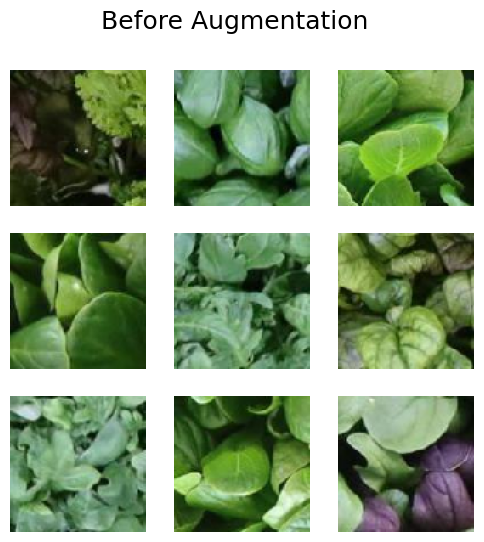

In [ ]:
visualize_dataset(train_dataset, title="Before Augmentation")

**Augmentation Layers**

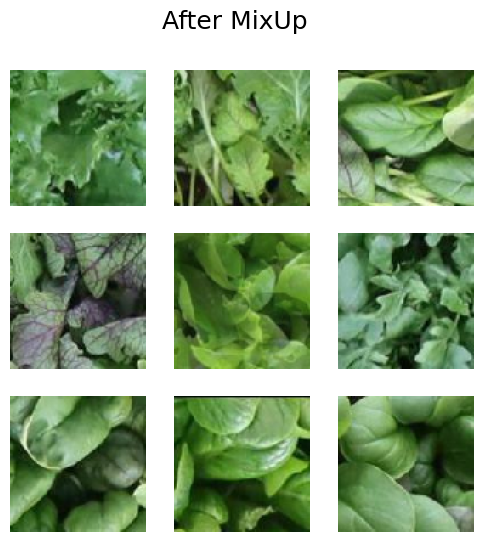

In [ ]:
mix_up = kcv.layers.MixUp()

def apply_mix_up(inputs):
    inputs = mix_up(inputs)
    return inputs

res = train_dataset.map(apply_mix_up, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After MixUp")

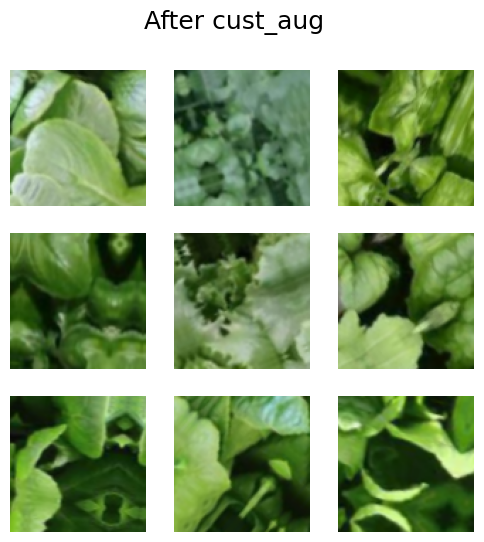

In [ ]:
cust_aug = tfk.Sequential([
    tkl.RandomTranslation(height_factor=(-0.3,0.3),width_factor=(-0.3,0.3)),
    tkl.RandomZoom(height_factor=(-0.2,0.2),width_factor=(-0.2,0.2)),
    tkl.RandomFlip(),
    tkl.RandomRotation(factor=0.25)
])

def apply_cust_aug(inputs):
    inputs["images"] = cust_aug(inputs["images"])
    return inputs

res = train_dataset.map(apply_cust_aug, num_parallel_calls=AUTOTUNE)

visualize_dataset(res, title="After cust_aug")

### Training

In [ ]:
def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

train_dataset = (
    train_dataset
    .map(apply_cust_aug, num_parallel_calls=AUTOTUNE)
    .map(apply_mix_up, num_parallel_calls=AUTOTUNE)
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

val_dataset = (
    val_dataset
    .map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

# Define the Model

In [ ]:
from keras.applications.convnext import preprocess_input

def apple_elixir_model(input_shape, output_shape):

  # TO CHANGE - res of the Model
  res = tfk.applications.ConvNeXtBase(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet",
    classes=2,
    classifier_activation='softmax'
  )

  res.trainable = False
  input_layer = tkl.Input(input_shape)

  x = preprocess_input(input_layer)
  x = res(x)
  x = tkl.GlobalAveragePooling2D()(x)
  x = tkl.Dense(units=128,activation=tkl.LeakyReLU(alpha=0.3))(x)                 # maybe we have to use leakyrelu
  x = tkl.Dropout(0.7)(x)

  output_layer = tkl.Dense(units=output_shape,activation='softmax')(x)
  model = tfk.Model(input_layer, output_layer)

  # Compile the model
  model.compile(
      loss=tfk.losses.CategoricalCrossentropy(),
      optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001),
      metrics=['accuracy', tfk.metrics.AUC()]
  )

  return model

model = apple_elixir_model(input_shape,output_shape)


350926856/350926856 [==============================] - 16s 0us/step


# Training

In [ ]:
# Train the model
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True
)

callbacks = [early_stopping]

history = model.fit(
    train_dataset,
    epochs = 300,
    validation_data = val_dataset,
    callbacks = callbacks
).history

Epoch 1/300
324/324 [==============================] - 67s 119ms/step - loss: 0.6409 - accuracy: 0.6854 - auc: 0.6800 - val_loss: 0.4678 - val_accuracy: 0.7662 - val_auc: 0.8571
Epoch 2/300
324/324 [==============================] - 26s 80ms/step - loss: 0.5331 - accuracy: 0.7486 - auc: 0.7371 - val_loss: 0.4341 - val_accuracy: 0.7985 - val_auc: 0.8863
Epoch 3/300
324/324 [==============================] - 26s 80ms/step - loss: 0.5193 - accuracy: 0.7575 - auc: 0.7414 - val_loss: 0.4568 - val_accuracy: 0.7760 - val_auc: 0.8629
Epoch 4/300
324/324 [==============================] - 26s 80ms/step - loss: 0.5143 - accuracy: 0.7629 - auc: 0.7445 - val_loss: 0.4069 - val_accuracy: 0.8133 - val_auc: 0.9009
Epoch 5/300
324/324 [==============================] - 26s 80ms/step - loss: 0.4997 - accuracy: 0.7718 - auc: 0.7449 - val_loss: 0.3934 - val_accuracy: 0.8111 - val_auc: 0.9026
Epoch 6/300
324/324 [==============================] - 26s 80ms/step - loss: 0.4935 - accuracy: 0.7782 - auc: 0.75

### Saving and Plotting

In [ ]:
NAME_MODEL = "ConvNeXtCV_004"
NAME_PLOT = NAME_MODEL + "_plot"
NAME_CMATRIX = NAME_MODEL + "_cmatrix"

**Plots Loss**

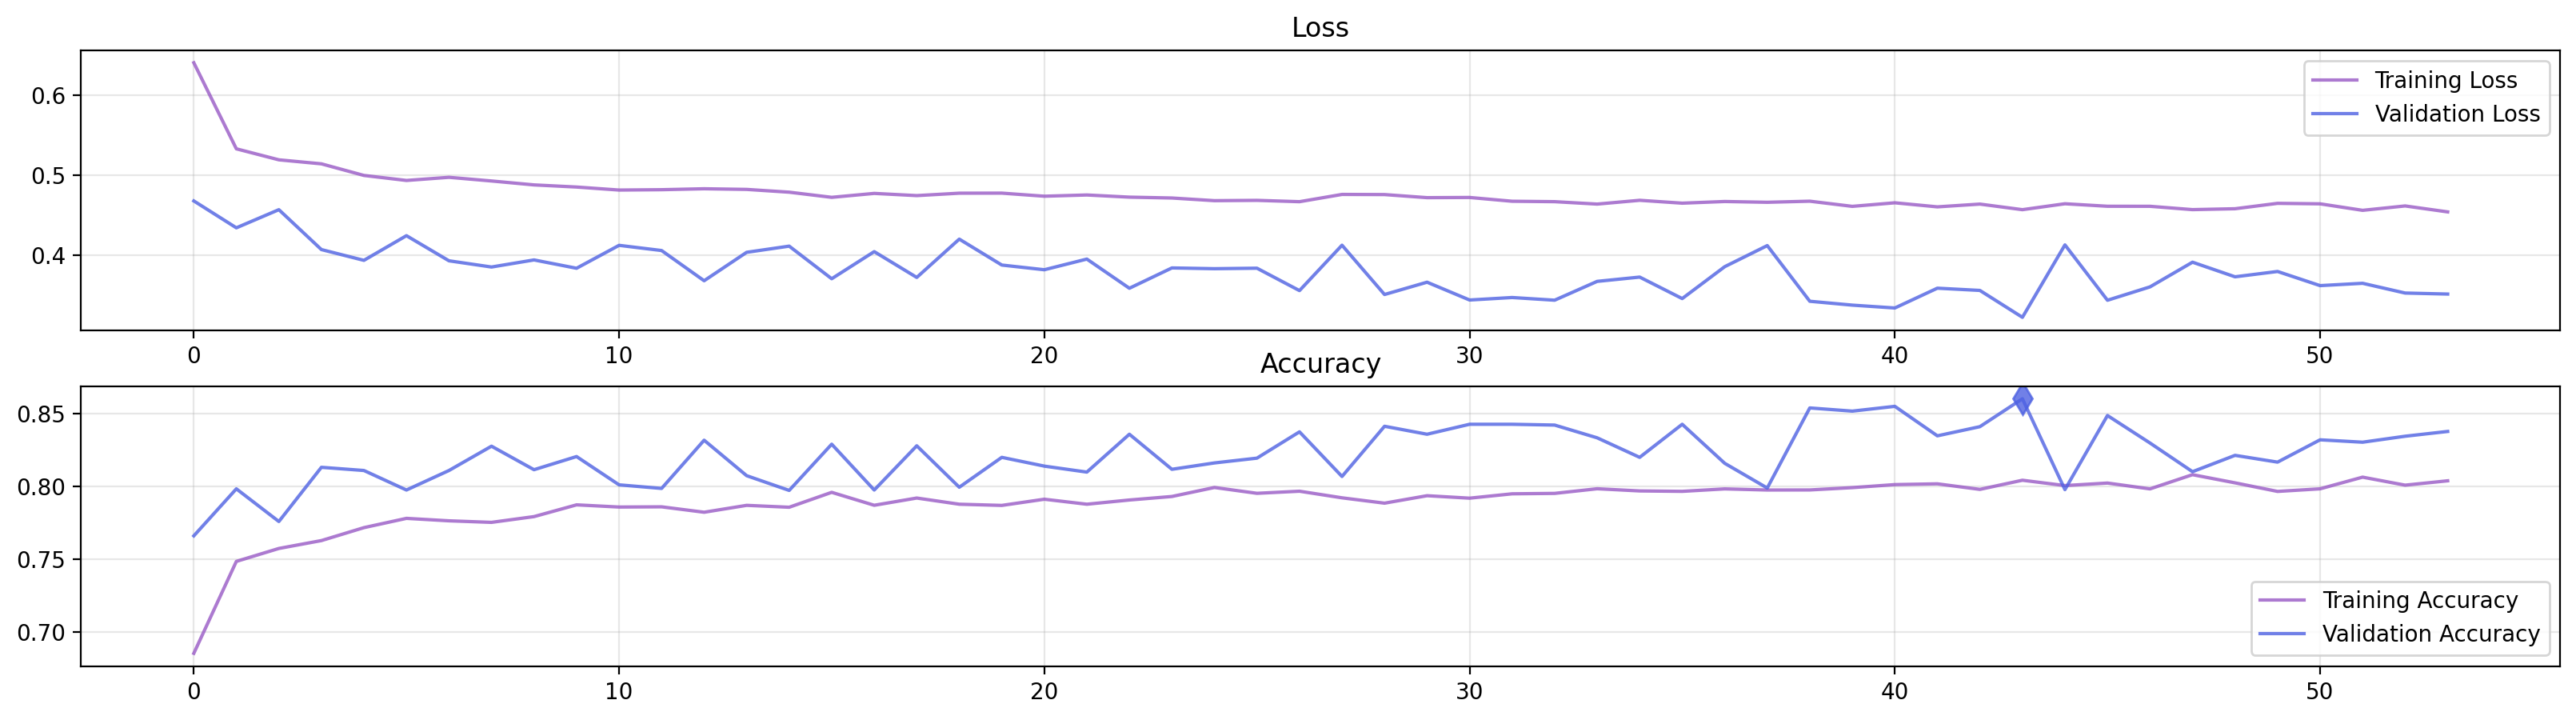

In [ ]:
plot_losses(history, (20,5), NAME_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.8659
Precision:	 0.8673
Recall:		 0.8659
F1:		 0.8658


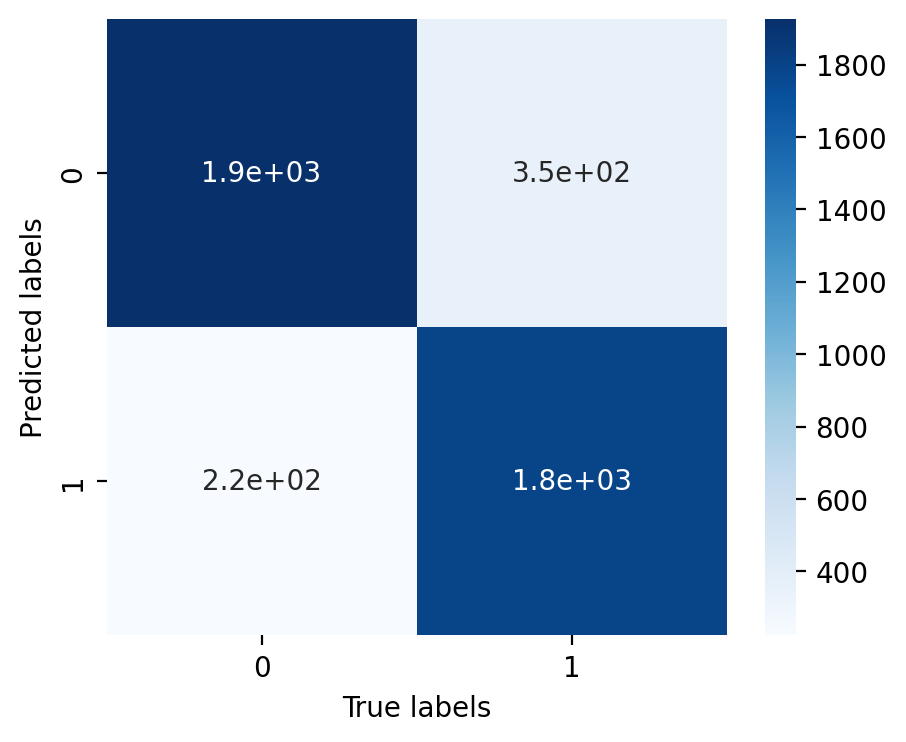

In [ ]:
plot_confusion_matrix(model, X_test, y_test, (5,4), NAME_CMATRIX)

**Save the Model**

In [ ]:
model.save(NAME_MODEL)

**Zip Model and Plots**

In [ ]:
!zip -r {NAME_MODEL}.zip {NAME_MODEL} {NAME_PLOT}.png {NAME_CMATRIX}.png

  adding: ConvNeXtCV_004/ (stored 0%)
  adding: ConvNeXtCV_004/variables/ (stored 0%)
  adding: ConvNeXtCV_004/variables/variables.index (deflated 77%)
  adding: ConvNeXtCV_004/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ConvNeXtCV_004/saved_model.pb (deflated 92%)
  adding: ConvNeXtCV_004/fingerprint.pb (stored 0%)
  adding: ConvNeXtCV_004/keras_metadata.pb (deflated 96%)
  adding: ConvNeXtCV_004/assets/ (stored 0%)
  adding: ConvNeXtCV_004_plot.png (deflated 11%)
  adding: ConvNeXtCV_004_cmatrix.png (deflated 15%)


In [ ]:
!cp {NAME_MODEL}.zip drive/MyDrive/

In [37]:
!cp augm_gio_split_004-pro.npz drive/MyDrive/

**Delete the Model**

In [ ]:
del model, history

# Fine Tuning

**Load the Model**

In [ ]:
ft_model = tfk.models.load_model(NAME_MODEL)

**Train only the Last Layers**

In [ ]:
ft_model.get_layer('convnext_base').trainable = True

for i, layer in enumerate(ft_model.get_layer('convnext_base').layers[:200]):
  layer.trainable=False

ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Nadam(learning_rate=0.001, weight_decay=0.001), metrics=['accuracy', tfk.metrics.AUC()])

**Train the Tuning Model**

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    mode='max',
    restore_best_weights=True)

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',         
    patience=5,                     
    factor=0.80,                    
    mode='max',                     
    min_lr=1e-7                     
)

callbacks = [early_stopping,lr_scheduler]

history = ft_model.fit(
    train_dataset,
    epochs = 300,
    validation_data = val_dataset,
    callbacks = callbacks
).history

Epoch 1/300
324/324 [==============================] - 106s 172ms/step - loss: 0.4843 - accuracy: 0.8065 - auc_1: 0.7686 - val_loss: 0.2572 - val_accuracy: 0.9036 - val_auc_1: 0.9625 - lr: 0.0010
Epoch 2/300
324/324 [==============================] - 42s 129ms/step - loss: 0.3831 - accuracy: 0.8575 - auc_1: 0.7975 - val_loss: 0.2430 - val_accuracy: 0.8932 - val_auc_1: 0.9651 - lr: 0.0010
Epoch 3/300
324/324 [==============================] - 42s 129ms/step - loss: 0.3487 - accuracy: 0.8832 - auc_1: 0.8113 - val_loss: 0.1837 - val_accuracy: 0.9255 - val_auc_1: 0.9799 - lr: 0.0010
Epoch 4/300
324/324 [==============================] - 42s 128ms/step - loss: 0.3258 - accuracy: 0.8929 - auc_1: 0.8156 - val_loss: 0.2030 - val_accuracy: 0.9231 - val_auc_1: 0.9742 - lr: 0.0010
Epoch 5/300
324/324 [==============================] - 42s 129ms/step - loss: 0.3085 - accuracy: 0.9015 - auc_1: 0.8183 - val_loss: 0.1517 - val_accuracy: 0.9499 - val_auc_1: 0.9853 - lr: 0.0010
Epoch 6/300
324/324 [===

### Saving and Plotting

In [ ]:
FT_NAME = NAME_MODEL+"_Tuning"
FT_PLOT = NAME_PLOT+"_Tuning"
FT_CMATRIX = NAME_CMATRIX+"_Tuning"

**Plot Loss**

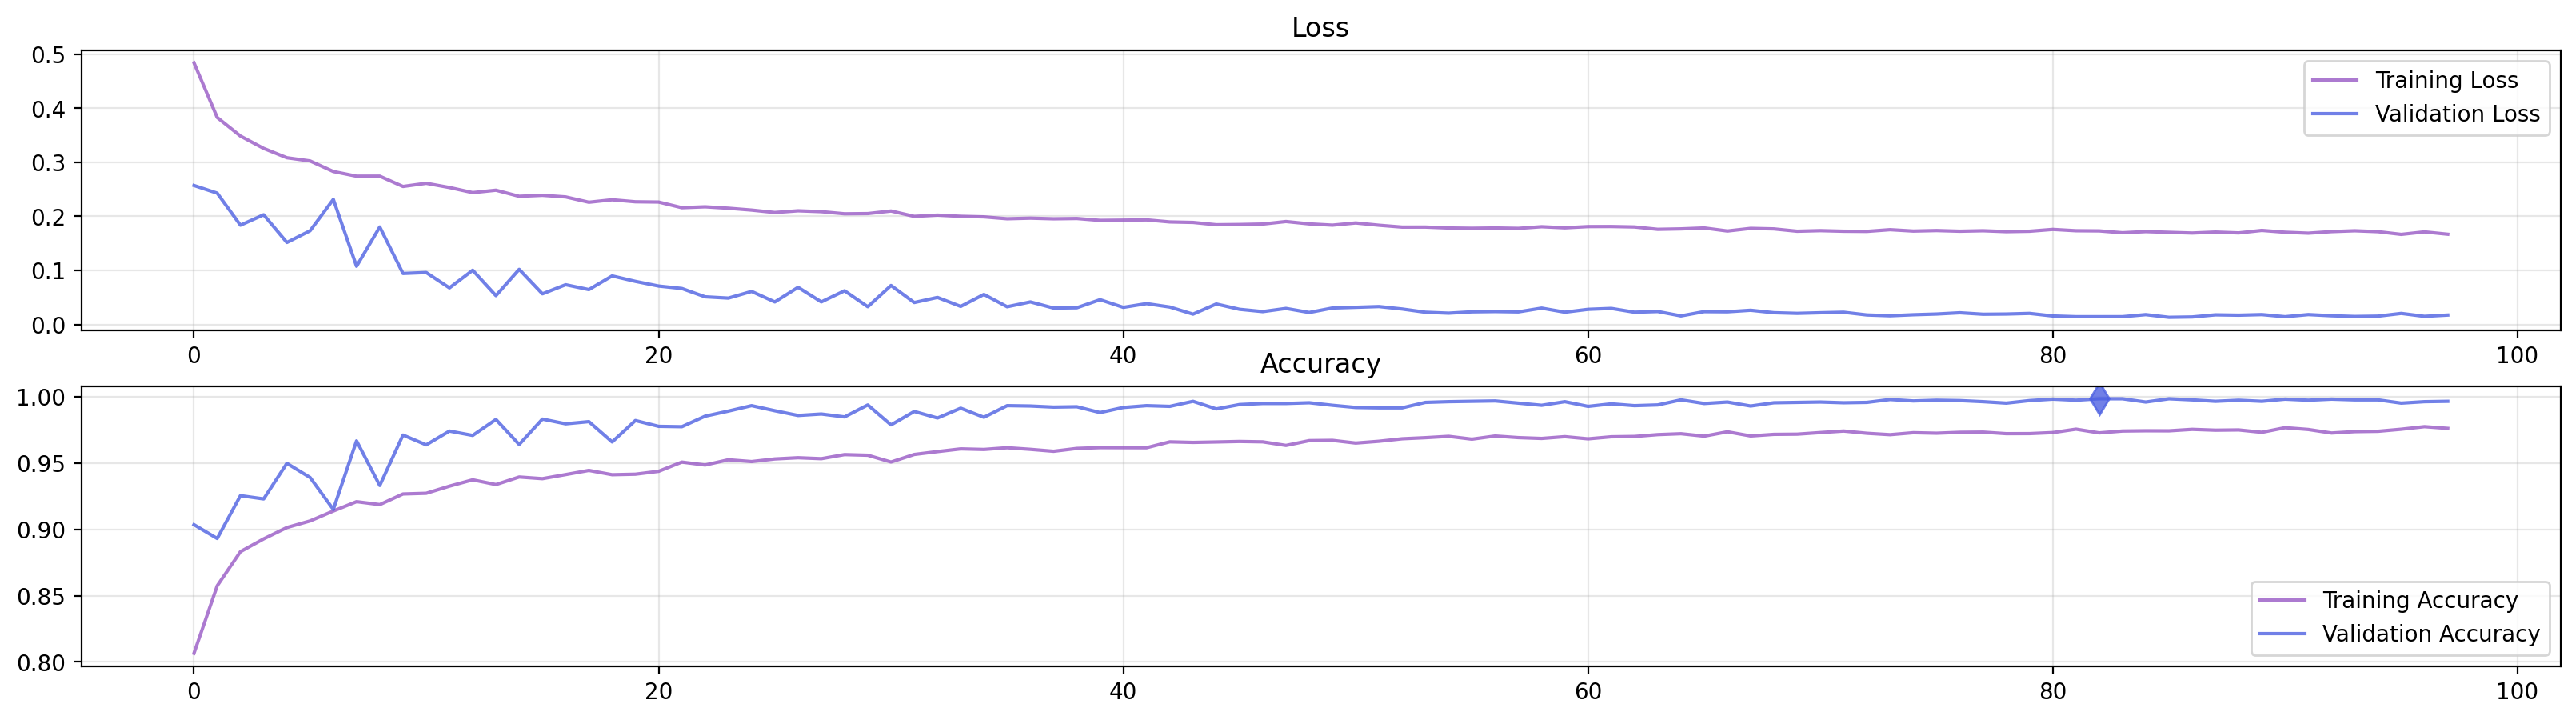

In [ ]:
plot_losses(history, (20,5), FT_PLOT)

**Plot Confusion Matrix**

Accuracy:	 0.9977
Precision:	 0.9977
Recall:		 0.9977
F1:		 0.9977


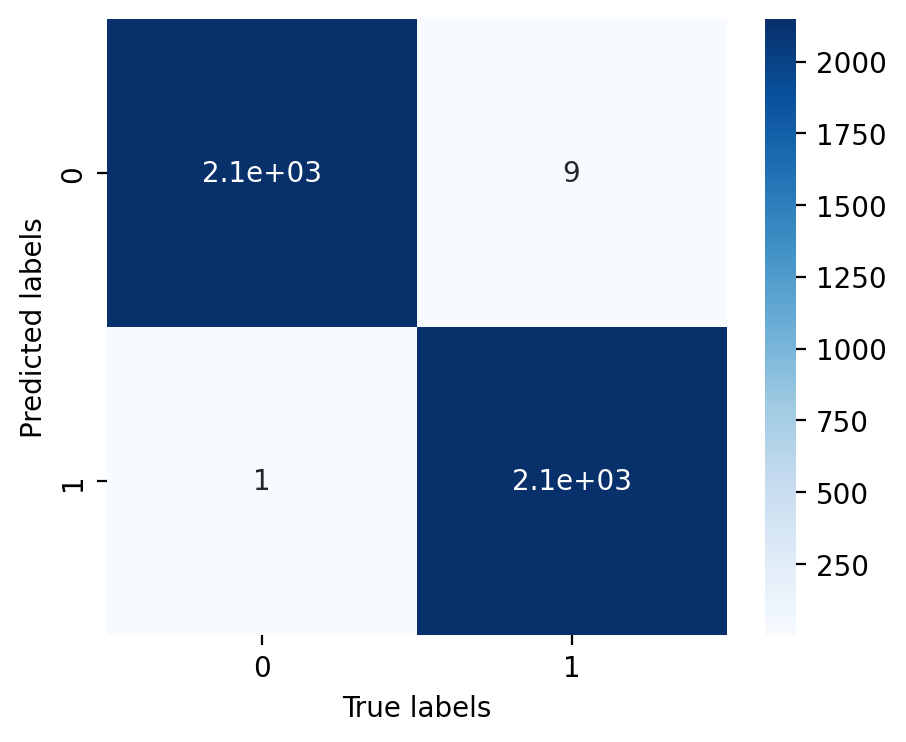

In [ ]:
plot_confusion_matrix(ft_model, X_test, y_test, (5,4), FT_CMATRIX)

**Save the Model**

In [ ]:
ft_model.save(FT_NAME)

**Zip the Model and the Plots**

In [ ]:
!zip -r {FT_NAME}.zip {FT_NAME} {FT_PLOT}.png {FT_CMATRIX}.png

In [ ]:
!cp {FT_NAME}.zip drive/MyDrive/

# Notes
We would like to thank the team of the 2023/2024 AN2DL course taught at Politecnico di Milano

More code available at this link: https://github.com/GioBar00/AN2DL_23-24_Apple_Elixir

Credits:
>*Andrea Alari*   https://github.com/andrea-alari

>*Giovanni Barbiero* https://github.com/GioBar00

>*Alexandro Sas*  https://github.com/AlexandroSas